In [6]:
# data_preprocessing.py
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split

# Load dataset
data = pd.read_csv('creditcard.csv')

# Check for missing values
print("Missing values in dataset:\n", data.isnull().sum())
if data.isnull().sum().sum() > 0:
    data = data.dropna()
    print("Dropped rows with missing values.")

# Separate features and target
X = data.drop('Class', axis=1)
y = data['Class']

# Scale Time and Amount
scaler = StandardScaler()
X[['Time', 'Amount']] = scaler.fit_transform(X[['Time', 'Amount']])

# Save scaler for deployment
import joblib
joblib.dump(scaler, 'scaler.pkl')

# Apply SMOTE with a lower sampling strategy to avoid overfitting
smote = SMOTE(sampling_strategy=0.5, random_state=42)  # 1:2 ratio of fraud to non-fraud
X_resampled, y_resampled = smote.fit_resample(X, y)

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Save processed data
X_train.to_csv('X_train.csv', index=False)
X_test.to_csv('X_test.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_test.to_csv('y_test.csv', index=False)

print("Data preprocessing completed. Training and test sets saved.")

Missing values in dataset:
 Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       1
V24       1
V25       1
V26       1
V27       1
V28       1
Amount    1
Class     1
dtype: int64
Dropped rows with missing values.
Data preprocessing completed. Training and test sets saved.


Class distribution:
 Class
0.0    0.995419
1.0    0.004581
Name: proportion, dtype: float64


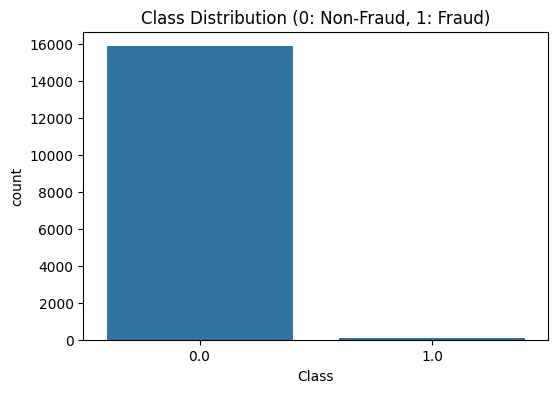

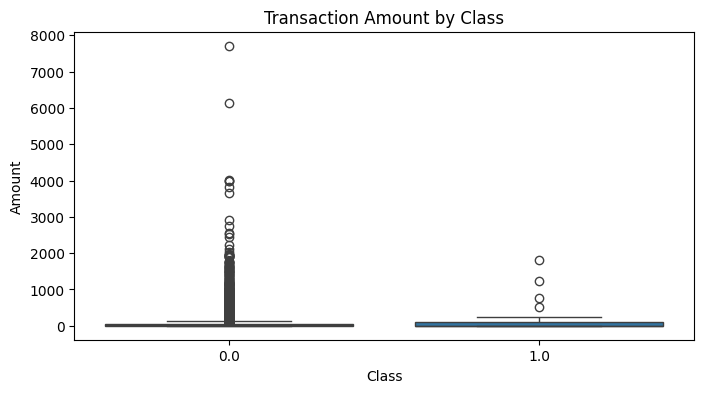

EDA completed. Visualizations saved.


In [7]:
# eda.py
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load dataset
data = pd.read_csv('creditcard.csv')

# Class distribution
print("Class distribution:\n", data['Class'].value_counts(normalize=True))
plt.figure(figsize=(6, 4))
sns.countplot(x='Class', data=data)
plt.title('Class Distribution (0: Non-Fraud, 1: Fraud)')
plt.savefig('class_distribution.png')
plt.show()

# Amount distribution by class
plt.figure(figsize=(8, 4))
sns.boxplot(x='Class', y='Amount', data=data)
plt.title('Transaction Amount by Class')
plt.savefig('amount_by_class.png')
plt.show()

print("EDA completed. Visualizations saved.")

In [8]:
# model_training.py
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import joblib

# Load processed data
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv').values.ravel()

# Define models and parameter grids
models = {
    'Random Forest': {
        'model': RandomForestClassifier(random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5],
            'class_weight': [{0: 1, 1: 2}]  # Increase weight for fraud class
        }
    },
    'XGBoost': {
        'model': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42),
        'params': {
            'n_estimators': [100, 200],
            'max_depth': [3, 6],
            'learning_rate': [0.01, 0.1],
            'scale_pos_weight': [2]  # Increase weight for fraud class
        }
    }
}

# Train and tune models
for name, config in models.items():
    print(f"Training {name} with GridSearchCV...")
    grid_search = GridSearchCV(
        estimator=config['model'],
        param_grid=config['params'],
        cv=5,  # 5-fold cross-validation
        scoring='precision',  # Optimize for precision
        n_jobs=-1
    )
    grid_search.fit(X_train, y_train)

    # Save best model
    best_model = grid_search.best_estimator_
    joblib.dump(best_model, f'{name.lower().replace(" ", "_")}_model.pkl')
    print(f"Best parameters for {name}: {grid_search.best_params_}")
    print(f"Best precision score: {grid_search.best_score_:.4f}")

print("Model training completed.")

Training Random Forest with GridSearchCV...
Best parameters for Random Forest: {'class_weight': {0: 1, 1: 2}, 'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Best precision score: 0.9992
Training XGBoost with GridSearchCV...


/usr/local/lib/python3.11/dist-packages/xgboost/training.py:183: UserWarning: [17:10:31] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best parameters for XGBoost: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 100, 'scale_pos_weight': 2}
Best precision score: 0.9986
Model training completed.



Evaluating Random Forest...
Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3190
         1.0       1.00      1.00      1.00      1569

    accuracy                           1.00      4759
   macro avg       1.00      1.00      1.00      4759
weighted avg       1.00      1.00      1.00      4759

ROC-AUC: 1.0000


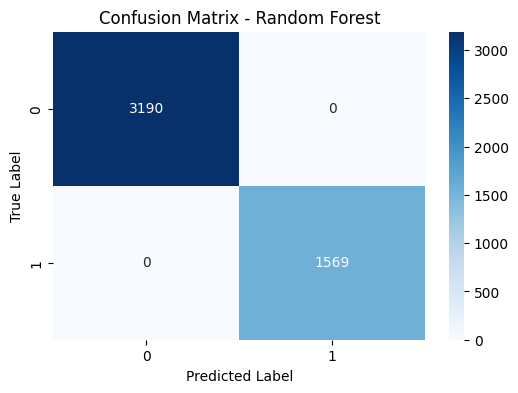


Evaluating XGBoost...
Accuracy: 1.0000
Classification Report:
               precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      3190
         1.0       1.00      1.00      1.00      1569

    accuracy                           1.00      4759
   macro avg       1.00      1.00      1.00      4759
weighted avg       1.00      1.00      1.00      4759

ROC-AUC: 1.0000


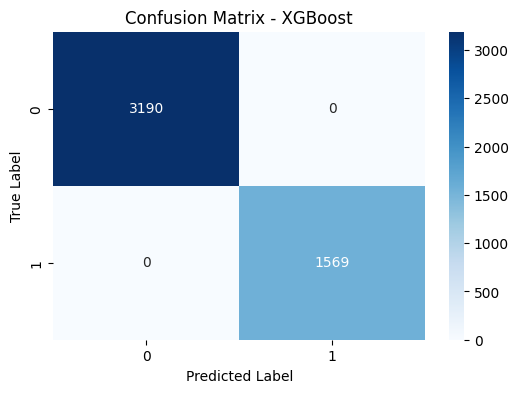

Model evaluation completed.


In [9]:
# model_evaluation.py
import pandas as pd
from sklearn.metrics import classification_report, roc_auc_score, accuracy_score, confusion_matrix
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

# Load test data
X_test = pd.read_csv('X_test.csv')
y_test = pd.read_csv('y_test.csv').values.ravel()

# Load models
models = {
    'Random Forest': joblib.load('random_forest_model.pkl'),
    'XGBoost': joblib.load('xgboost_model.pkl')
}

# Evaluate models
for name, model in models.items():
    print(f"\nEvaluating {name}...")
    y_pred = model.predict(X_test)

    # Metrics
    print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
    print(f"Classification Report:\n", classification_report(y_test, y_pred))
    print(f"ROC-AUC: {roc_auc_score(y_test, model.predict_proba(X_test)[:, 1]):.4f}")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix - {name}')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.savefig(f'confusion_matrix_{name.lower().replace(" ", "_")}.png')
    plt.show()

print("Model evaluation completed.")

In [ ]:
# app_gradio.py
import gradio as gr
import pandas as pd
import joblib
import numpy as np

# Load the trained model and scaler
model = joblib.load('Credit card Fraud Prediction Model/models/random_forest_model.pkl')  # Replace with your best model (e.g., xgboost_model.pkl)
scaler = joblib.load('Credit card Fraud Prediction Model/scalers/scaler.pkl')

# Define the prediction function
def predict_fraud(Time, V1, V2, V3, V4, V5, V6, V7, V8, V9, V10, V11, V12, V13, V14,
                  V15, V16, V17, V18, V19, V20, V21, V22, V23, V24, V25, V26, V27, V28, Amount):
    try:
        # Create a dictionary from inputs
        input_data = {
            'Time': Time, 'V1': V1, 'V2': V2, 'V3': V3, 'V4': V4, 'V5': V5, 'V6': V6, 'V7': V7,
            'V8': V8, 'V9': V9, 'V10': V10, 'V11': V11, 'V12': V12, 'V13': V13, 'V14': V14,
            'V15': V15, 'V16': V16, 'V17': V17, 'V18': V18, 'V19': V19, 'V20': V20, 'V21': V21,
            'V22': V22, 'V23': V23, 'V24': V24, 'V25': V25, 'V26': V26, 'V27': V27, 'V28': V28,
            'Amount': Amount
        }

        # Convert to DataFrame
        df = pd.DataFrame([input_data])

        # Scale Time and Amount
        df[['Time', 'Amount']] = scaler.transform(df[['Time', 'Amount']])

        # Predict
        prediction = model.predict(df)[0]
        probability = model.predict_proba(df)[0][1]

        # Format output
        result = "Fraud" if prediction == 1 else "Not Fraud"
        return f"Prediction: {result}", f"Fraud Probability: {probability:.4f}"

    except Exception as e:
        return f"Error: {str(e)}", ""

# Create Gradio interface
iface = gr.Interface(
    fn=predict_fraud,
    inputs=[
        gr.Number(label="Time"),
        gr.Number(label="V1"), gr.Number(label="V2"), gr.Number(label="V3"), gr.Number(label="V4"),
        gr.Number(label="V5"), gr.Number(label="V6"), gr.Number(label="V7"), gr.Number(label="V8"),
        gr.Number(label="V9"), gr.Number(label="V10"), gr.Number(label="V11"), gr.Number(label="V12"),
        gr.Number(label="V13"), gr.Number(label="V14"), gr.Number(label="V15"), gr.Number(label="V16"),
        gr.Number(label="V17"), gr.Number(label="V18"), gr.Number(label="V19"), gr.Number(label="V20"),
        gr.Number(label="V21"), gr.Number(label="V22"), gr.Number(label="V23"), gr.Number(label="V24"),
        gr.Number(label="V25"), gr.Number(label="V26"), gr.Number(label="V27"), gr.Number(label="V28"),
        gr.Number(label="Amount")
    ],
    outputs=[gr.Textbox(label="Prediction"), gr.Textbox(label="Fraud Probability")],
    title="Credit Card Fraud Detection",
    description="Enter transaction details to predict if it's fraudulent. Features V1–V28 are PCA-transformed, Time is in seconds, and Amount is the transaction amount."
)

# Launch the interface
iface.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://636ceecd39bb677596.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
